<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/project_ATPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO DO**:
  1. Compute results for other models (change parameters) and compare.
  2. Code doesn't run for the second model

**Doubts**:
  1. what if the same word appears 2x in the same review/newswire, is that explicit in the tensor?

# Project: Part 1

## Functions and libraries needed

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib, shutil, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, TextVectorization, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Set a fixed random seed value
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Vectorizing text inputs

In [3]:
# Vectorizing text
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)

### Pre-trained embedding layer - GloVe

In [4]:
# Run only once
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-04-30 10:11:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-30 10:11:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-30 10:11:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
# Run only once
!unzip -q glove.6B.zip

In [6]:
# Loading pre-trained word embedding (GloVe)   PAGE 333 BOOK
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [7]:
embedding_dim = 100
max_tokens = 20000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# vocab = vectorizer.get_vocabulary()
# word_index = {word: idx for idx, word in enumerate(vocab)}

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [8]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
    )

## Model 1: Binary sentiment classification

### Dataset


In [9]:
# Run only once
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.6M      0  0:00:03  0:00:03 --:--:-- 21.6M


In [10]:
base_dir = pathlib.Path("aclImdb")

val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
  os.makedirs(val_dir / category)
  files = os.listdir(train_dir / category)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move(train_dir / category / fname,
                val_dir / category / fname)

In [11]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size)

val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size)

test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [12]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### CNN model - first architecture type

In [13]:
# Most simple model

model1_cnn = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model1_cnn.compile(
    optimizer='adam',               # better than rmsprop
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history1_cnn = model1_cnn.fit(binary_1gram_train_ds,
                    epochs=20,
                    batch_size=512,
                    validation_data=binary_1gram_val_ds,
                    callbacks=[early_stopping])

model1_cnn.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8190 - loss: 0.4106 - val_accuracy: 0.8904 - val_loss: 0.2707
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9414 - loss: 0.1598 - val_accuracy: 0.8856 - val_loss: 0.3038
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9752 - loss: 0.0722 - val_accuracy: 0.8794 - val_loss: 0.4053
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9943 - loss: 0.0237 - val_accuracy: 0.8806 - val_loss: 0.4936


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,921,733 (7.33 MB)

 Trainable params: 640,577 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,281,156 (4.89 MB)

With model1_cnn we have around 89% val_accuracy.

In [15]:
# Functional model (from the book)
def get_model(max_tokens=20000, hidden_dim=16):
  inputs = keras.Input(shape=(max_tokens,))
  x = layers.Dense(hidden_dim, activation="relu")(inputs)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics=["accuracy"])
  return model

In [16]:
model2_cnn = get_model()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
    ]

history2_cnn = model2_cnn.fit(binary_1gram_train_ds.cache(),
                              validation_data=binary_1gram_val_ds.cache(),
                              epochs=10,
                              callbacks=callbacks)

model2_cnn.summary()

model2_cnn = keras.models.load_model("binary_1gram.keras")

print(f"Test acc: {model2_cnn.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7532 - loss: 0.5192 - val_accuracy: 0.8874 - val_loss: 0.2873
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8886 - loss: 0.2943 - val_accuracy: 0.8954 - val_loss: 0.2738
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9056 - loss: 0.2573 - val_accuracy: 0.8892 - val_loss: 0.2902
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9183 - loss: 0.2408 - val_accuracy: 0.8938 - val_loss: 0.2943
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9222 - loss: 0.2261 - val_accuracy: 0.8892 - val_loss: 0.3097
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9268 - loss: 0.2236 - val_accuracy: 0.8882 - val_loss: 0.3227
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9277 - loss: 0.2136 - val_accuracy: 0.8832 - val_loss: 0.3337
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9302 - loss: 0.2111 - val_acc

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,068 (2.44 MB)

 Trainable params: 320,033 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,035 (1.22 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8852 - loss: 0.2896
Test acc: 0.888


With model2_cnn we have around 90% val_accuracy.

#### Plotting:

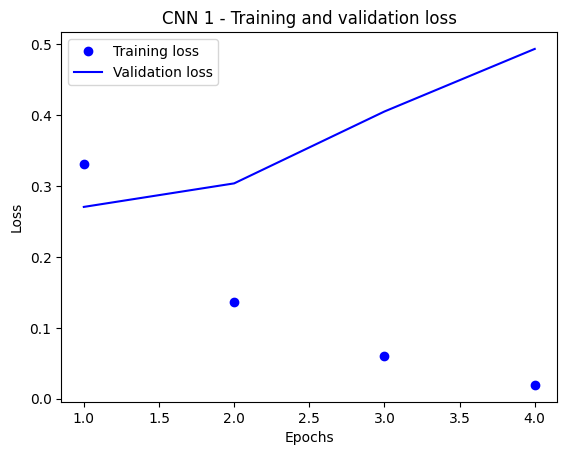

In [17]:
# Loss
history_dict = history1_cnn.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

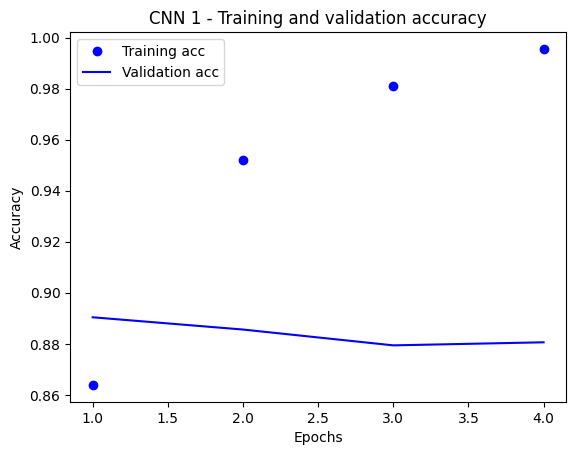

In [18]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

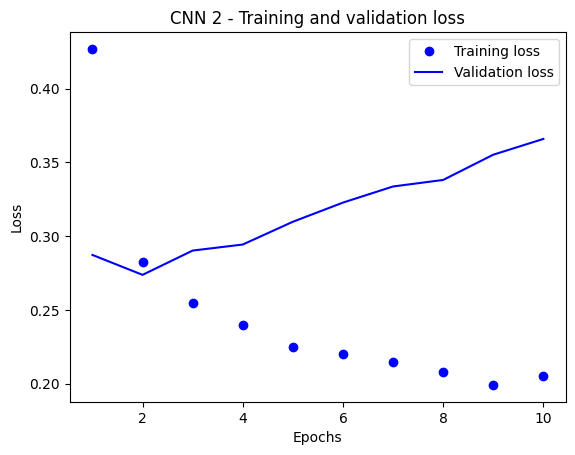

In [19]:
# Loss
history_dict = history2_cnn.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 2 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

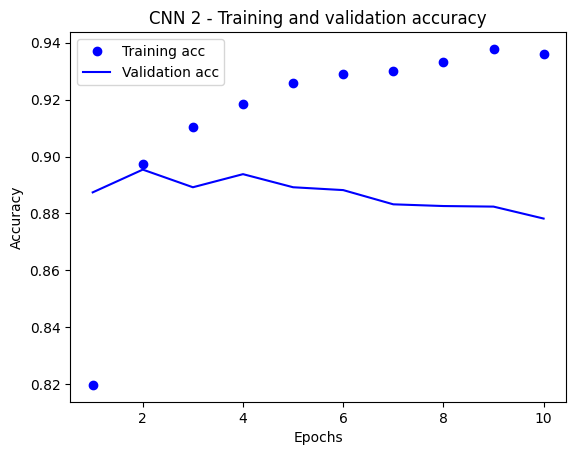

In [20]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 2 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### LSTM model - second architecture type

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

callbacks = [
keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                save_best_only=True)
]

history1_lstm = model.fit(binary_1gram_train_ds, validation_data=binary_1gram_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("glove_embeddings_sequence_model.keras")

print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 100) │  2,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     34,048 │ embedding[2][0],  │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,034,113 (7.76 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
 88/625 ━━━━━━━━━━━━━━━━━━━━ 3:24:34 23s/step - accuracy: 0.4936 - loss: 0.6938

#### Plotting:

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final model

Retraining the model in all the train data and evaluation in test data.
After that we are computing the results.

In [ ]:
# Train the model
history = model_lstm.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        keras.callbacks.ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
    ]
)

In [ ]:
model = keras.Sequential([
    ])

model.compile(optimizer=,
              loss=,
              metrics=)

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(x_test, y_test)

results

Making predictions:

In [ ]:
model.predict(x_test)

### Can we improve the model? How?

We experiment different architecture:
1. Add another layer / Take out one layer.
2. Increse/Decrease perceptrons inside layers (usualy factors of 8: 32, 64, 128).
3. Try 'mse' for loss function.
4. Try 'tanh' for activation function.

In [ ]:
# Model that uses pre trained embedding (book)
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])
model.summary()
callbacks = [
keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

##  Model 2: Multi-class emotion detection

In [ ]:
from tensorflow.keras.datasets import reuters   # Dataset with news labeled with a topic

### Dataset

(using reuters dataset inside tensorflow.keras.datasets)

In [ ]:
df_1= pd.read_csv("goemotions_1.csv")
df_2= pd.read_csv("goemotions_2.csv")
df_3= pd.read_csv("goemotions_3.csv")

In [ ]:
(train_data, train_labels),(test_data, test_labels) = reuters.load_data(num_words = 100000)
# again we are only interested in the TOP10000 words

#### not necessary

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
len(train_labels)

Note that the format of the data is the same as in the previous case, where each piece of news is encode into a list of integers, being each of them correspondent to a word.

Extra: decoding back to word (same as in imdb case)

In [ ]:
word_index = reuters.get_word_index()    # dict that maps each word to its code number

reverse_word_index = dict(            # dict inverting value and key (number to word)
    [(value, key) for (key, value) in word_index.items()])

# Decoding train_data[0]
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_newswire

### Turning lists into tensors (same code as before)

In [ ]:
# Dont understand this error
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
# Vectorizing labels (diferent than in the previous case because there are more than 2 labels)

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

# this yields a matrix with 46 dimensions(columns),
# where all values in a row are 0 except in the column with the number of the correct label

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [ ]:
# There is all this built in way to do it
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(train_labels)
# y_test = to_categorical(test_labels)

### CNN model

In [ ]:
max_features = 10000   # Define maximum number of words to consider in the vocabulary
maxlen = 500           # Define sequence length (truncate or pad sequences to this length)
embedding_dim = 128    # Embedding dimension

# Create the model
model_cnn = keras.Sequential([
    # Embedding layer to convert word indices to dense vectors
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),

    # 1D CNN layers for extracting n-gram features
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.GlobalMaxPooling1D(),

    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer="rmsprop",            # choosing optimizer
#               loss="binary_crossentropy",     # choosing loss function
#               metrics=["accuracy"])

Let's compute validation datasets.

In [ ]:
# Splitting train into partial_train and validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Let's now train the model

In [ ]:
history = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

#### Plotting

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Transformer model

In [ ]:
# Define parameters
max_features = 10000  # Size of vocabulary
maxlen = 500  # Max sequence length
embedding_dim = 128  # Embedding dimension

# Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(
        inputs + attention_output
    )

    # Feed-forward network
    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)

    # Second residual connection and layer normalization
    return layers.LayerNormalization(epsilon=1e-6)(
        attention_output + ffn_output
    )

# Define input
inputs = layers.Input(shape=(maxlen,))

# Embedding layer
x = layers.Embedding(max_features, embedding_dim)(inputs)

# Add positional encoding
positions = tf.range(start=0, limit=maxlen, delta=1)
position_embedding = layers.Embedding(
    input_dim=maxlen, output_dim=embedding_dim
)(positions)
x = x + position_embedding

# Apply dropout
x = layers.Dropout(0.1)(x)

# Apply transformer blocks
transformer_blocks = 2
for _ in range(transformer_blocks):
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

# Pool across sequence dimension and apply classification layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Build the model
model_transf = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_transf.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model
history = model_transf.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        keras.callbacks.ModelCheckpoint('best_transformer_model.h5', save_best_only=True)
    ]
)

In [ ]:
model_transf.summary()

In [ ]:
# Evaluate on test set
test_loss, test_acc = model_transf.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')
"""

### Final model

In [ ]:
# what does this do?
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

Making predictions:

In [ ]:
predictions = model.predict(x_test)